Fitting 3 folds for each of 2 candidates, totalling 6 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 592
[LightGBM] [Info] Number of data points in the train set: 906, number of used features: 60
[LightGBM] [Info] Start training from score -0.175721
[LightGBM] [Info] Start training from score -2.748596
[LightGBM] [Info] Start training from score -4.411144
[LightGBM] [Info] Start training from score -3.441743
[LightGBM] [Info] Start training from score -4.506454
[LightGBM] [Info] Start training from score -4.863129
[LightGBM] [Info] Start training from score -4.036451
[LightGBM] [Info] Start training from score -4.100989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

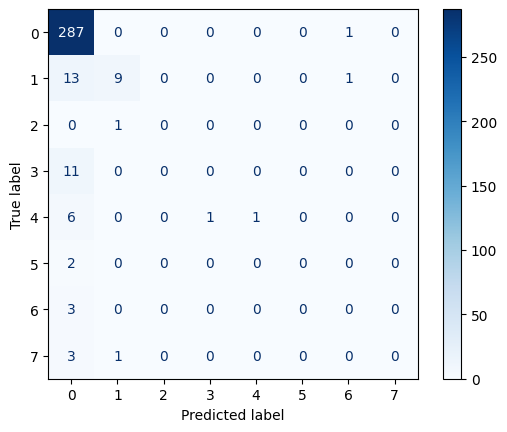

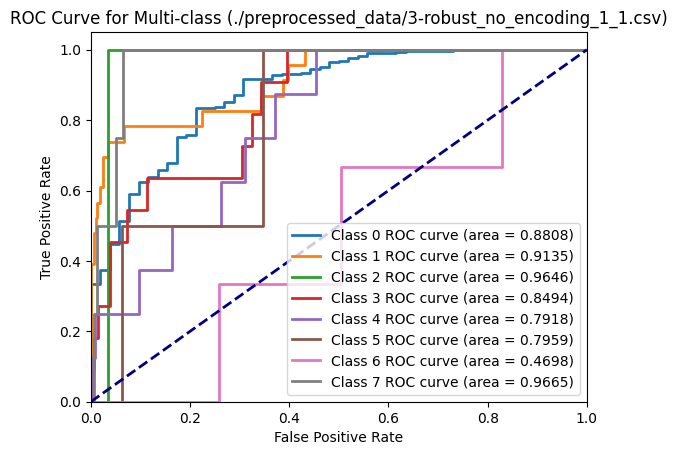

In [4]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

def run_model(scaled_file, target_file):
    # Load the datasets
    scaled_df = pd.read_csv(scaled_file)
    target_df = pd.read_csv(target_file)

    if 'Unnamed: 0' in scaled_df.columns:
        scaled_df = scaled_df.drop(columns=['Unnamed: 0'])
        
    # Extract the target variable
    y = target_df['LET_IS']

    # Encode the categorical target variable if needed
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(scaled_df, y_encoded, test_size=0.2, random_state=42)

    # Create the LightGBM model
    lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=8, random_state=42)

    # Define the parameter grid
    param_grid = {
        'learning_rate': [0.1, 0.3],
        # 'num_leaves': [31, 50, 100],
        # 'max_depth': [-1, 10, 20],
    }

    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='roc_auc_ovr', cv=3, verbose=1)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Display the best parameters
    print(f"Best parameters found for {scaled_file}: ", grid_search.best_params_)

    # Use the best model to make predictions
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test)
    y_pred = best_model.predict(X_test)

    # Calculate the AUC score (One-vs-Rest)
    auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    print(f'Multi-class AUC score for {scaled_file}: {auc_score:.4f}')

    # Calculate the F1 scores
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    print(f'F1 Micro score for {scaled_file}: {f1_micro:.4f}')
    print(f'F1 Macro score for {scaled_file}: {f1_macro:.4f}')

    # Plot the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Plot the ROC curve for each class
    plt.figure()
    for i in range(8):
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} ROC curve (area = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Multi-class ({scaled_file})')
    plt.legend(loc='lower right')
    plt.show()

# Specific scaled file
scaled_file = './preprocessed_data/3-robust_no_encoding_1_1.csv'

# Target file
target_file = './rawdata/target.csv'

# Run the model for the specified scaled file
run_model(scaled_file, target_file)
